<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

# Exploration et Nettoyage des données



## Librairies

In [1]:
#Importation des librairies utilisées
import unicodedata 
import time
import pandas as pd
import numpy as np
import random
import nltk
import collections
import itertools
import warnings

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")

import sklearn.cross_validation as scv

/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Si vous utilisez la librairie `nltk` pour la première fois, il est nécessaire d'utiliser la commande suivante. Cette commande permet de télécharger de nombreux corpus de texte, mais également des informations grammaticales sur différentes langues. Information notamment nécessaire à l'étape de racinisation.

In [2]:
# nltk.download()

## Importation des données

* `cdiscount_train`: 1.000.000 de lignes
* `cdisount_test`: 50.000 lignes

   ### Read & Split Dataset
   On définit une fonction permettant de lire le fichier d'apprentissage et de créer deux DataFrame Pandas, un pour l'apprentissage, l'autre pour la validation.
   
   La fonction créée un DataFrame en lisant entièrement le fichier. Puis elle scinde ce DataFrame en deux grâce à la fonction dédiée de sklearn. 

In [3]:
def split_dataset(input_path, nb_line, tauxValid):
    data_all = pd.read_csv(input_path,sep=",", nrows=nb_line)
    data_all = data_all.fillna("")
    data_train, data_valid = scv.train_test_split(data_all, test_size = tauxValid)
    time_end = time.time()
    return data_train, data_valid

In [4]:
input_path = "data/cdiscount_train.csv.zip"
nb_line=100000  # part totale extraite du fichier initial ici déjà réduit
tauxValid = 0.05
data_train, data_valid = split_dataset(input_path, nb_line, tauxValid)
# Cette ligne permet de visualiser les 5 premières lignes de la DataFrame 
N_train = data_train.shape[0]
N_valid = data_valid.shape[0]
print("Train set : %d elements, Test set : %d elements" %(N_train, N_valid))
data_train.head(5)

Train set : 95000 elements, Test set : 5000 elements


,Categorie1,Categorie2,Categorie3,Description,Libelle,Marque
30249,LIBRAIRIE,SCIENCES HUMAINES,PSYCHOLOGIE,"Spaces to Play - Clark, Alison - Spaces to Pla...","Spaces to Play - Clark, Alison",AUCUNE
97122,LIBRAIRIE,AUTRES LIVRES,AUTRES LIVRES,De Floret aux éditions MENGES,Livre d'or de notre mariage,
61247,LIBRAIRIE,AUTRES LIVRES,AUTRES LIVRES,Aktion Grammatik! - Trudi McMahon - Aktion Gra...,Aktion Grammatik! - Trudi McMahon,AUCUNE
32447,BIJOUX - LUNETTES - MONTRES,MONTRES,MONTRE BRACELET,70816012 Montre Femme Quartz - Montre Performe...,70816012 Montre Femme Quartz,PERFORMER
23433,INFORMATIQUE,IMPRESSION - SCANNER,TONER - RECUPERATEUR DE TONER,Pack de 4 Toner Q6000A Q6001A Q6002A Q6003A Co...,Q6002A compatible HP Pack de 4 Toner couleurs,AUCUNE


In [38]:
data_train.groupby("Categorie1").first()[["Description","Marque"]]

,Description,Marque
Categorie1,,
ADULTE - EROTIQUE,Shorty Modal Gris - Ceinture Camouflage - Boxe...,CALVIN KLEIN
ANIMALERIE - NEW,FLATAZOR Protect Dermato 12 kg - Aliment compl...,FLATAZOR
ARME DE COMBAT - ARME DE SPORT,MALLETTE AIRSOFT BEIGE TAN 31 x 23 x 6.5 CM - ...,AUCUNE
ART DE LA TABLE - ARTICLES CULINAIRES,"Couteau Santoku 15,2cm Type 301 P03 - Dimensio...",AUCUNE
ARTICLES POUR FUMEUR,Pack E-Cigarette ONE WHITE BOX NOMADE - Retrou...,CILEX ONE
AUTO - MOTO (NEW),Kit Amortisseurs + Ressorts AP Suspensions BMW...,AUCUNE
BAGAGERIE,Sac de voyage à roulettes Quiksilver reference...,QUIKSILVER
BATEAU MOTEUR - VOILIER,Cordages Lalizas Mooring Double Braided Rope P...,LALIZAS
BIJOUX - LUNETTES - MONTRES,70816012 Montre Femme Quartz - Montre Performe...,PERFORMER


### Distribution des classes

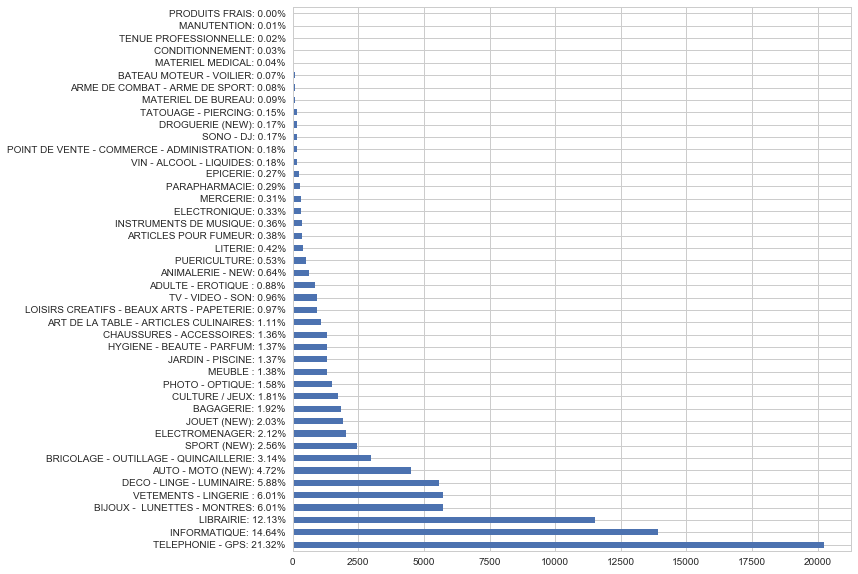

In [5]:
#Count occurence of each Categorie
data_count = data_train["Categorie1"].value_counts()
#Rename index to add percentage
new_index = [k+ ": %.2f%%" %(v*100/N_train) for k,v in data_count.iteritems()]
data_count.index= new_index

fig=plt.figure(figsize= (10,10))
ax = fig.add_subplot(1,1,1)
data_count.plot.barh(logx = False)
plt.show()

Que peut-on dire sur la distribution des ce classes?

### Sauvegarde des données

On sauvegarde dans des csv les fichiers `train` et `validation` afin que ces mêmes fichiers soit ré-utilisés plus tard dans d'autre calepin

In [6]:
data_valid.to_csv("data/cdiscount_valid.csv", index=False)
data_train.to_csv("data/cdiscount_train_subset.csv", index=False)

##  Nettoyage des données
Afin de limiter la dimension de l'espace des variables ou *features*, tout en conservant les informations essentielles, il est nécessaire de nettoyer les données en appliquant plusieurs étapes:
* Chaque mot est écrit en minuscule.
* Les termes numériques, de ponctuation et autres symboles sont supprimés.
* 155 mots-courants, et donc non informatifs, de la langue française sont supprimés (STOPWORDS). Ex: le, la, du, alors, etc...
* Chaque mot est "racinisé", via la fonction `STEMMER.stem` de la librairie nltk. La racinisation transforme un mot en son radical ou sa racine. Par exemple, les mots: cheval, chevaux, chevalier, chevalerie, chevaucher sont tous remplacés par "cheva".

### Importation des librairies et fichier pour le nettoyage des données.

In [7]:
# Librairies 
from bs4 import BeautifulSoup #Nettoyage d'HTML
import re # Regex
import nltk # Nettoyage des données

## listes de mots à supprimer dans la description des produits
## Depuis NLTK
nltk_stopwords = nltk.corpus.stopwords.words('french') 
## Depuis Un fichier externe.
lucene_stopwords =open("data/lucene_stopwords.txt","r").read().split(",") #En local
## Union des deux fichiers de stopwords 
stopwords = list(set(nltk_stopwords).union(set(lucene_stopwords)))

## Fonction de setmming de stemming permettant la racinisation
stemmer=nltk.stem.SnowballStemmer('french')

### Exemple 

**Ligne Originale**

In [8]:
i = 0
description = data_train.Description.values[i]
print("Original Description : " + description)

Original Description : Spaces to Play - Clark, Alison - Spaces to Play - Clark, Alison… Voir la présentation


** Supprime les posibles balises HTML dans la description **

In [9]:
txt = BeautifulSoup(description,"html.parser",from_encoding='utf-8').get_text()
print(txt)

Spaces to Play - Clark, Alison - Spaces to Play - Clark, Alison… Voir la présentation


/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/bs4/__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")


** Convertit le texte en minuscule **

In [10]:
txt = txt.lower()
print(txt)

spaces to play - clark, alison - spaces to play - clark, alison… voir la présentation


** Remplace quelques caractères spéciaux **

* `\u2026`: `…`
* `\u00a0`: `NO-BREAK SPACE`

Cette liste peut être etayer en fonction du jeu de donées étudiés

In [11]:
txt = txt.replace(u'\u2026','.')    
txt = txt.replace(u'\u00a0',' ')
print(txt)

spaces to play - clark, alison - spaces to play - clark, alison. voir la présentation


** Supprime les accents **

In [12]:
txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8")
print(txt)

spaces to play - clark, alison - spaces to play - clark, alison. voir la presentation


** Supprime les caractères qui ne sont ne sont pas des lettres minuscules **

In [13]:
txt = re.sub('[^a-z_]', ' ', txt)
print(txt)

spaces to play   clark  alison   spaces to play   clark  alison  voir la presentation


** Remplace la description par une liste de mots (tokens), supprime les mots de moins de 2 lettres ainsi que les stopwords **


In [14]:
tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
print(tokens)

['spaces', 'play', 'clark', 'alison', 'spaces', 'play', 'clark', 'alison', 'voir', 'presentation']


** Racinise (Stem) chaque tokens **

In [15]:
tokens_stem = [stemmer.stem(token) for token in tokens]
print(tokens_stem)

['spac', 'play', 'clark', 'alison', 'spac', 'play', 'clark', 'alison', 'voir', 'present']


### Fonction de nettoyage de texte
Fonction qui prend en entrée un texte et retourne le texte nettoyé en appliquant successivement les étapes présentés précedemment. 

In [16]:
# Fonction clean générale
def clean_txt(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text()
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8")
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
    ### french stemming
    tokens_stem = [stemmer.stem(token) for token in tokens]
    ### tokens = stemmer.stemWords(tokens)
    return ' '.join(tokens), " ".join(tokens_stem)

def clean_marque(txt):
    txt = re.sub('[^a-zA-Z0-9]', '_', txt).lower()
    return txt

Applique le nettoyage sur toutes les lignes de la DataFrame et créé deux nouvelles Dataframe (avant et sans l'étape de racinisation).

In [17]:
from multiprocessing import Pool
p = Pool(4)
    
# fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df(input_data, column_names= ['Description', 'Libelle', 'Marque']):

    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    clean_stem_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Marque":
            array_clean = np.array(list(p.map(clean_marque,column)))
            clean_list.append(array_clean)
            clean_stem_list.append(array_clean)
        else:
            A = np.array(list(p.map(clean_txt,column)))
            array_clean = A[:,0]
            array_clean_stem = A[:,1]
            clean_list.append(array_clean)
            clean_stem_list.append(array_clean_stem)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    
    array_clean_stem = np.array(clean_stem_list).T
    data_clean_stem = pd.DataFrame(array_clean_stem, columns = column_names)
    return data_clean, data_clean_stem

/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/bs4/__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/bs4/__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/bs4/__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will 

### Nettoyage des DataFrames

In [18]:
# Take approximately 2 minutes fors 100.000 rows
data_valid_clean, data_valid_clean_stem = clean_df(data_valid)

Start Clean 5000 lines
Cleaning time: 2 secondes


In [19]:
data_train_clean, data_train_clean_stem = clean_df(data_train)

Start Clean 95000 lines
Cleaning time: 36 secondes


Affiche les 5 premières lignes de la DataFrame d'apprentissage après nettoyage.

In [20]:
data_train_clean.head(5)

,Description,Libelle,Marque
0,spaces play clark alison spaces play clark ali...,spaces play clark alison,aucune
1,floret editions menges,livre mariage,
2,aktion grammatik trudi mcmahon aktion grammati...,aktion grammatik trudi mcmahon,aucune
3,montre femme quartz montre performer femme typ...,montre femme quartz,performer
4,pack toner compatible imprimantes color laserj...,compatible pack toner couleurs,aucune


In [21]:
data_train_clean_stem.head(5)

,Description,Libelle,Marque
0,spac play clark alison spac play clark alison ...,spac play clark alison,aucune
1,floret edit meng,livr mariag,
2,aktion grammatik trud mcmahon aktion grammatik...,aktion grammatik trud mcmahon,aucune
3,montr femm quartz montr perform femm typ mouv ...,montr femm quartz,performer
4,pack ton compatibl imprim color laserjet canon...,compatibl pack ton couleur,aucune


Taille du dictionnaire de mots pour le dataset avant et après la racinisation.

In [22]:
concatenate_text = " ".join(data_train_clean["Description"].values)
list_of_word = concatenate_text.split(" ")
N = len(set(list_of_word))
print(N)

72733


In [23]:
concatenate_text = " ".join(data_train_clean_stem["Description"].values)
list_of_word_stem = concatenate_text.split(" ")
N = len(set(list_of_word_stem))
print(N)

56579


### Wordcloud

In [24]:
from wordcloud import WordCloud

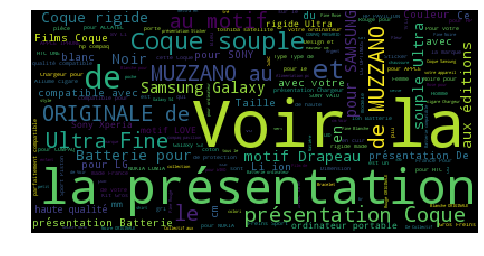

In [25]:
all_descr = " ".join(data_valid.Description.values)
wordcloud_word = WordCloud(background_color="black").generate_from_text(all_descr)

plt.figure()
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

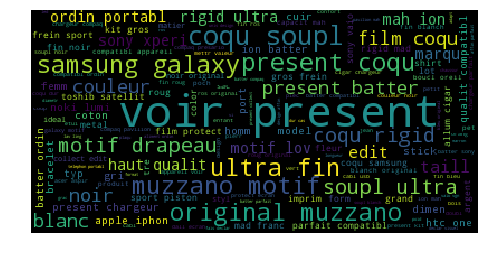

In [26]:
all_descr_clean_stem = " ".join(data_valid_clean_stem.Description.values)
wordcloud_word = WordCloud(background_color="black").generate_from_text(all_descr_clean_stem)

plt.figure()
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

## Sauvegarde des jeux de données nettoyés dans des fichiers csv.

In [27]:
data_valid_clean.to_csv("data/cdiscount_valid_clean.csv", index=False)
data_train_clean.to_csv("data/cdiscount_train_clean.csv", index=False)

data_valid_clean_stem.to_csv("data/cdiscount_valid_clean_stem.csv", index=False)
data_train_clean_stem.to_csv("data/cdiscount_train_clean_stem.csv", index=False)